# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden 7 July 2020 - Review required

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
Change paramter to **False** when running on your own local machine, but do not commit this change! Leave as **True** for Github Action `rtlive-model.yaml` to run remotely.

In [2]:
remote_run = False

## Troubleshooting

1. Ensure that all modules are installed with pip or conda from `requirments.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

While testing, run US model first to baseline the latest model files. For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [4]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [5]:
region = "OR"
model_data = df.loc[region]

In [6]:
model_data.tail()

,positive,total
date,,
2020-07-02,363.0,7694.0
2020-07-03,0.0,0.0
2020-07-04,636.0,3972.0
2020-07-05,300.0,9175.0
2020-07-06,165.0,3520.0


## Create the model instance and sample

In [7]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [10:02<00:00,  5.97draws/s]


## Summarize Model Output

In [8]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:01<00:00, 410.14it/s]


In [9]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-06-27,1.143778,1.140176,0.918724,1.310589,157.098828,143.904406,153.140198,174.0,3296.0
2020-06-28,1.144655,1.137667,0.916895,1.320284,161.791209,147.704632,153.140198,174.0,3296.0
2020-06-29,1.146656,1.147993,0.921093,1.328614,166.737075,151.622987,23.544370,144.0,17742.0
2020-06-30,1.144214,1.140817,0.920162,1.341416,171.990481,155.670378,198.339666,171.0,2501.0
2020-07-01,1.147338,1.141063,0.926781,1.363498,177.580927,159.858748,139.318410,275.0,5726.0
2020-07-02,1.147721,1.144287,0.909489,1.367381,183.489902,164.203551,136.861597,363.0,7694.0
2020-07-03,1.145663,1.141267,0.925959,1.386021,189.765565,168.720136,0.000000,0.0,0.0
2020-07-04,1.144871,1.136385,0.902419,1.363998,196.468770,173.420765,464.488573,636.0,3972.0
2020-07-05,1.148302,1.141733,0.898542,1.379811,203.558465,178.320473,94.851093,300.0,9175.0


## Plot Model Output

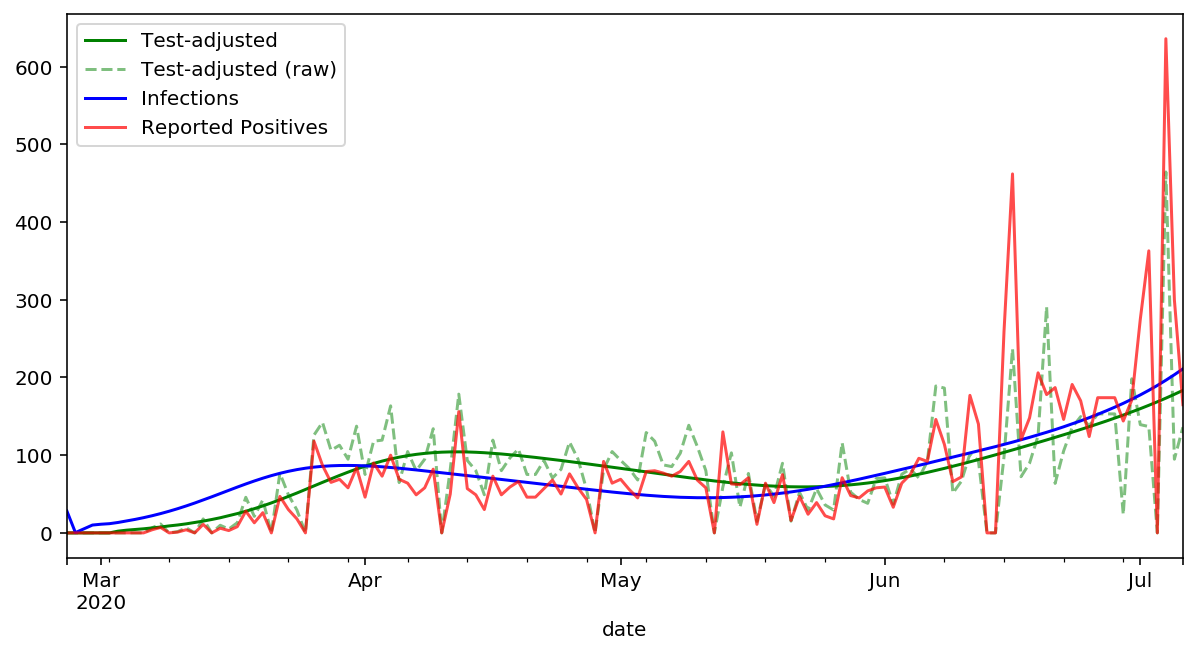

In [10]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
    
plot_results()

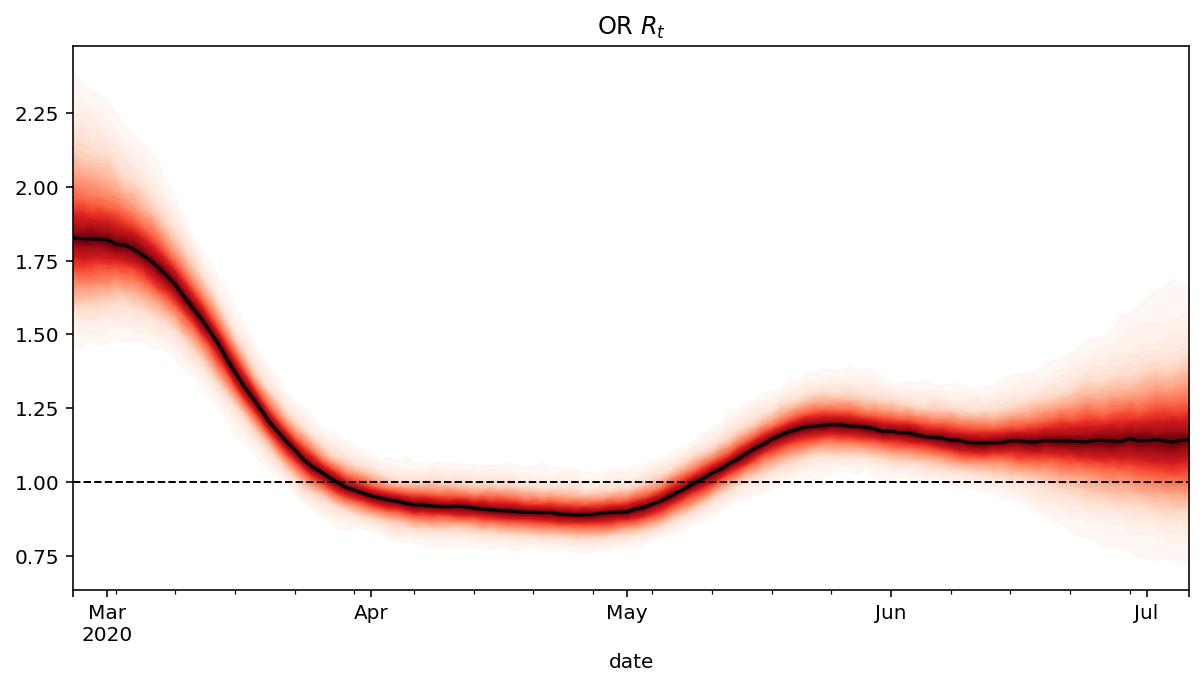

In [11]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
    
plot_rt()

# South African Results

In [12]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-02,20200702,30603.0,1886.0,49937.0,11669.0,1286.0,1478.0,573.0,4788.0,65841.0,0.0,168061,https://twitter.com/DrZweliMkhize/status/12787...
2020-07-03,20200703,32157.0,2130.0,54331.0,12757.0,1408.0,1611.0,626.0,5168.0,66936.0,0.0,177124,https://twitter.com/nicd_sa/status/12791261637...
2020-07-04,20200704,34161.0,2376.0,59373.0,13984.0,1559.0,1818.0,686.0,5644.0,68376.0,0.0,187977,https://twitter.com/nicd_sa/status/12795389507...
2020-07-05,20200705,35648.0,2553.0,63404.0,15146.0,1706.0,1965.0,734.0,6063.0,69531.0,0.0,196750,https://twitter.com/nicd_sa/status/12798466117...
2020-07-06,20200706,38081.0,2804.0,66891.0,15819.0,1785.0,2173.0,820.0,6410.0,70938.0,0.0,205721,https://twitter.com/COVID_19_ZA/status/1280252...


In [13]:
#url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-07-02,20200702,1706127.0,81999,NaN,NaN,NaN,2844,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/02/update-...
2020-07-03,20200703,1745153.0,86298,NaN,NaN,NaN,2952,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/03/update-...
2020-07-04,20200704,1792078.0,91227,NaN,NaN,NaN,3026,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/04/update-...
2020-07-05,20200705,1830161.0,93315,NaN,NaN,NaN,3199,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/05/update-...
2020-07-06,20200706,1864111.0,97848,NaN,NaN,NaN,3310,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/06/update-...


In [14]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-07-02    168061
2020-07-03    177124
2020-07-04    187977
2020-07-05    196750
2020-07-06    205721
Name: cases, Length: 122, dtype: int64

In [15]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-07-06 00:00:00'))

In [16]:
idx = pd.date_range(casezero, caselast)

In [17]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-07-02    1706127.0
2020-07-03    1745153.0
2020-07-04    1792078.0
2020-07-05    1830161.0
2020-07-06    1864111.0
Name: tests, Length: 129, dtype: float64

In [18]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-07-02    1706127.0
2020-07-03    1745153.0
2020-07-04    1792078.0
2020-07-05    1830161.0
2020-07-06    1864111.0
Name: tests, Length: 120, dtype: float64

In [19]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-02,168061.0,1706127.0
2020-07-03,177124.0,1745153.0
2020-07-04,187977.0,1792078.0


In [20]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [21]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-02,168061.0,1706127.0
2020-07-03,177124.0,1745153.0
2020-07-04,187977.0,1792078.0
2020-07-05,196750.0,1830161.0


In [22]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-07-02,168061.0,1706127.0
2020-07-03,177124.0,1745153.0
2020-07-04,187977.0,1792078.0
2020-07-05,196750.0,1830161.0


In [23]:
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-07-02,168061.0,1706127.0,8728.0,39188.0
2020-07-03,177124.0,1745153.0,9063.0,39026.0
2020-07-04,187977.0,1792078.0,10853.0,46925.0
2020-07-05,196750.0,1830161.0,8773.0,38083.0


In [24]:
df_model = final_filled_model.iloc[1:-1]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-07-01,159333.0,1666939.0,8124.0,36931.0
2020-07-02,168061.0,1706127.0,8728.0,39188.0
2020-07-03,177124.0,1745153.0,9063.0,39026.0
2020-07-04,187977.0,1792078.0,10853.0,46925.0


In [25]:
region = 'Total RSA'

In [26]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [09:37<00:00,  6.23draws/s]


In [27]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:02<00:00, 390.07it/s]


In [28]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-06-26,1.199287,1.185238,0.973468,1.350749,4773.576132,4679.673129,4954.214110,6215.0,33092.0
2020-06-27,1.198650,1.186729,0.983586,1.379002,4960.961409,4849.177063,5297.085564,7210.0,35905.0
2020-06-28,1.200727,1.184418,0.976538,1.386443,5159.910972,5025.279428,4388.284760,6334.0,38075.0
2020-06-29,1.199052,1.187843,0.956644,1.387852,5370.105909,5208.283617,5406.126407,6130.0,29911.0
2020-06-30,1.199829,1.184205,0.959494,1.392948,5593.300972,5398.736682,5549.372948,6945.0,33013.0
2020-07-01,1.198861,1.176456,0.964616,1.405606,5830.376215,5597.294112,5802.771934,8124.0,36931.0
2020-07-02,1.198835,1.181529,0.942921,1.393570,6082.040615,5804.559213,5875.140985,8728.0,39188.0
2020-07-03,1.201249,1.189943,0.960271,1.430090,6348.939135,6021.264708,6125.966173,9063.0,39026.0
2020-07-04,1.203719,1.190460,0.949351,1.439564,6632.212786,6248.318583,6101.016173,10853.0,46925.0


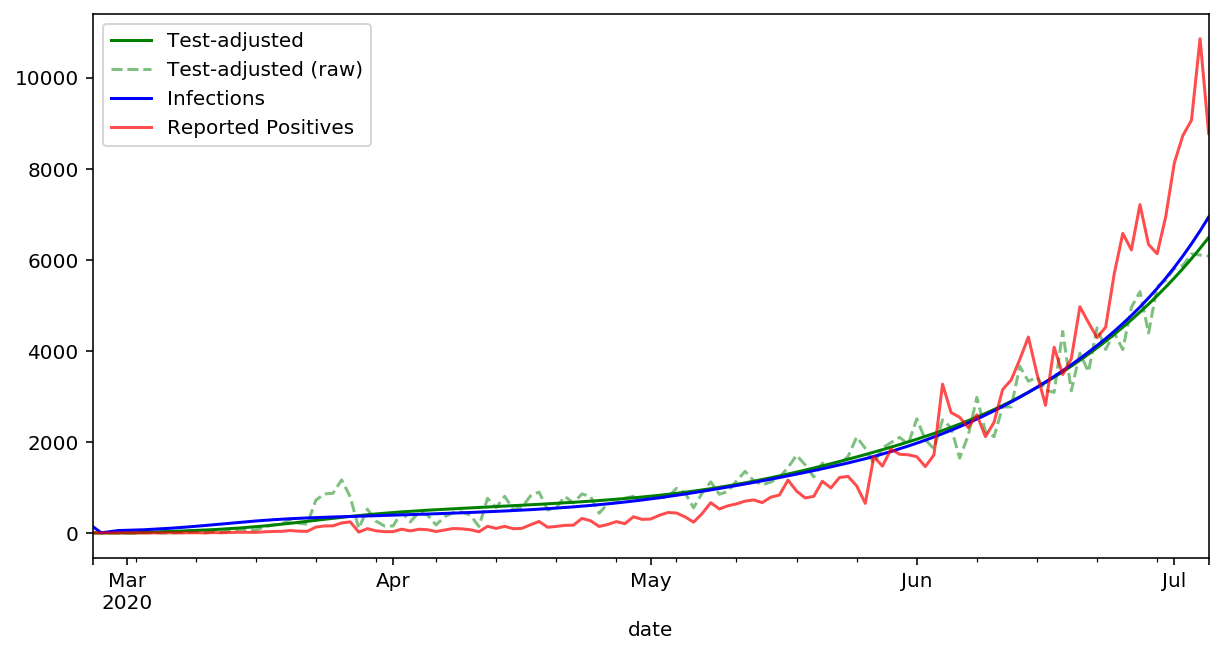

In [29]:
plot_results()

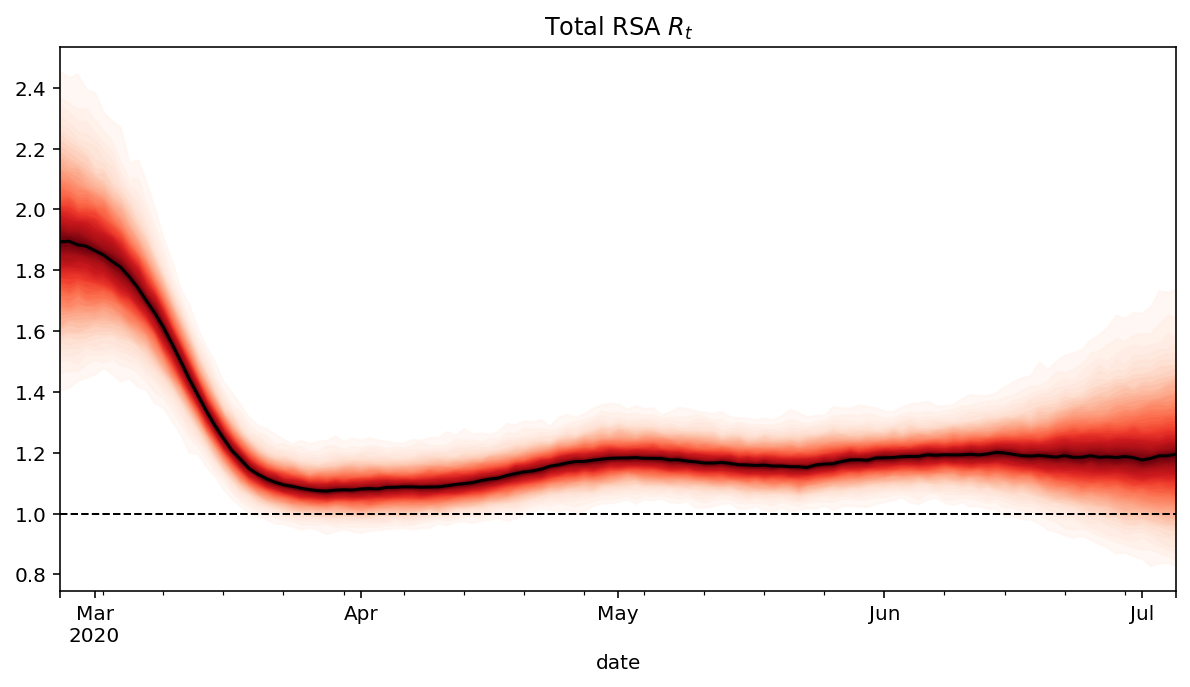

In [30]:
plot_rt()

In [31]:
export_results = result[['median','upper_80','lower_80']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80'})
export_results.tail()

,Median,High_80,Low_80
date,,,
2020-07-01,1.176456,1.405606,0.964616
2020-07-02,1.181529,1.393570,0.942921
2020-07-03,1.189943,1.430090,0.960271
2020-07-04,1.190460,1.439564,0.949351
2020-07-05,1.195253,1.447444,0.942748


In [32]:
if remote_run:
    # Used by GitHub Action, TODO complete the action!
    # The path needs to be linked directly, TODO find out why relative path does not work
    # Action instance path /home/runner/work/covid19za/covid19za
    export_results.to_csv('data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')

else:
    export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')